# License Information

# NYC Data wrangling using IPython Notebook and SQL Server

This notebook demonstrates data exploration and feature generation using Python and SQL queries for data stored in SQL Server in Azure. We start with reading a sample of the data into a Pandas data frame and visualizing and exploring the data. We show how to use Python to execute SQL queries against the data and manipulate data directly within the SQL Server on Azure.

This IPNB is accompanying material to the data Azure Data Science in Action walkthrough document (https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-sql-walkthrough/) and uses the New York City Taxi dataset (http://www.andresmh.com/nyctaxitrips/).

## Read data in Pandas frame for visualizations

We start with loading a sample of the data in a Pandas data frame and performing some explorations on the sample. 

We join the Trip and Fare data and sub-sample the data to load a 0.1% sample of the dataset in a Pandas dataframe. We assume that the Trip and Fare tables have been created and loaded from the taxi dataset mentioned earlier. If you haven't done this already please refer to the 'Move Data to SQL Server on Azure' article linked from the Cloud Data Science process map.

#### Import required packages in this experiment

In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pyodbc
import os
from azure.storage.blob import BlobService
import tables
import time

#### Set plot inline

In [3]:
%matplotlib inline

#### Initialize Database Credentials

In [4]:
SERVER_NAME = '<server name>'
DATABASE_NAME = '<database name>'
USERID = '<user name>'
PASSWORD = '<password>'
DB_DRIVER = '<database server>'

#### Create Database Connection

In [49]:
driver = 'DRIVER={' + DB_DRIVER + '}'
server = 'SERVER=' + SERVER_NAME 
database = 'DATABASE=' + DATABASE_NAME
uid = 'UID=' + USERID 
pwd = 'PWD=' + PASSWORD

In [50]:
CONNECTION_STRING = ';'.join([driver,server,database,uid,pwd, ';TDS_VERSION=7.3;Port=1433'])
print CONNECTION_STRING
conn = pyodbc.connect(CONNECTION_STRING)

DRIVER={SQL Server Native Client 11.0};SERVER=x;DATABASE=x;UID=x;PWD=x;;TDS_VERSION=7.3;Port=1433


#### Report number of rows and columns in table nyctaxi_trip

In [10]:
nrows = pd.read_sql('''SELECT SUM(rows) FROM sys.partitions WHERE object_id = OBJECT_ID('nyctaxi_trip')''', conn)
print 'Total number of rows = %d' % nrows.iloc[0,0]

ncols = pd.read_sql('''SELECT count(*) FROM information_schema.columns WHERE table_name = ('nyctaxi_trip')''', conn)
print 'Total number of columns = %d' % ncols.iloc[0,0]

Total number of rows = 173179759
Total number of columns = 14


#### Report number of rows and columns in table nyctaxi_fare

In [11]:
nrows = pd.read_sql('''SELECT SUM(rows) FROM sys.partitions WHERE object_id = OBJECT_ID('nyctaxi_fare')''', conn)
print 'Total number of rows = %d' % nrows.iloc[0,0]

ncols = pd.read_sql('''SELECT count(*) FROM information_schema.columns WHERE table_name = ('nyctaxi_fare')''', conn)
print 'Total number of columns = %d' % ncols.iloc[0,0]

Total number of rows = 173179759
Total number of columns = 11


#### Read-in data from SQL Server

In [14]:
t0 = time.time()

#load only a small percentage of the joined data for some quick visuals
df1 = pd.read_sql('''select top 10000 t.*, f.payment_type, f.fare_amount, f.surcharge, f.mta_tax, 
      f.tolls_amount, f.total_amount, f.tip_amount 
      from nyctaxi_trip t, nyctaxi_fare f where datepart("mi",t.pickup_datetime)=0 and t.medallion = f.medallion 
      and t.hack_license = f.hack_license and t.pickup_datetime = f.pickup_datetime''', conn)

t1 = time.time()
print 'Time to read the sample table is %f seconds' % (t1-t0)

print 'Number of rows and columns retrieved = (%d, %d)' % (df1.shape[0], df1.shape[1])

Time to read the sample table is 14.096495 seconds
Number of rows and columns retrieved = (10000, 21)


#### Descriptive Statistics

Now we can explore the 0.05 percent sample data. We start with looking at descriptive statistics for trip distance:

In [15]:
df1['trip_distance'].describe()

count    10000.000000
mean         2.017111
std          2.946393
min          0.000000
25%          0.800000
50%          1.200000
75%          1.980000
max         40.600000
Name: trip_distance, dtype: float64

#### Box Plot

Next we look at the box plot for trip distance to visualize quantiles

{'boxes': [<matplotlib.lines.Line2D at 0x7f9080fe9b90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9080ffcad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9080f8cdd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9080f8c790>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9080fe9d90>,
  <matplotlib.lines.Line2D at 0x7f9080ffc490>]}

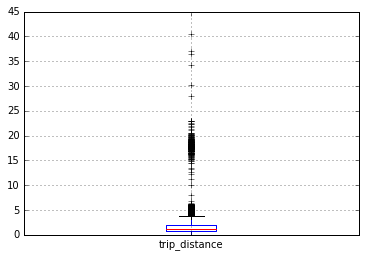

In [16]:
df1.boxplot(column='trip_distance',return_type='dict')

#### Distribution Plot

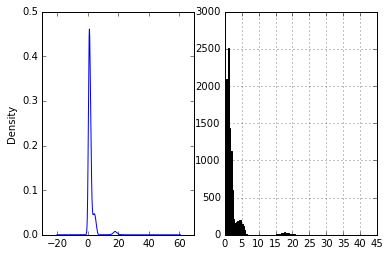

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
df1['trip_distance'].plot(ax=ax1,kind='kde', style='b-')
df1['trip_distance'].hist(ax=ax2, bins=100, color='k')

#### Binning trip_distance

In [18]:
trip_dist_bins = [0, 1, 2, 4, 10, 1000]
df1['trip_distance']
trip_dist_bin_id = pd.cut(df1['trip_distance'], trip_dist_bins)
trip_dist_bin_id

0           (0, 1]
1           (1, 2]
2       (10, 1000]
3           (1, 2]
4           (0, 1]
5           (0, 1]
6           (0, 1]
7           (0, 1]
8           (0, 1]
9           (0, 1]
10          (1, 2]
11          (0, 1]
12          (1, 2]
13          (0, 1]
14          (0, 1]
15          (1, 2]
16         (4, 10]
17          (1, 2]
18          (0, 1]
19          (0, 1]
20          (0, 1]
21          (1, 2]
22          (0, 1]
23          (1, 2]
24          (1, 2]
25          (0, 1]
26          (0, 1]
27          (1, 2]
28          (1, 2]
29          (0, 1]
           ...    
9970        (1, 2]
9971        (1, 2]
9972        (2, 4]
9973        (0, 1]
9974        (2, 4]
9975        (2, 4]
9976        (1, 2]
9977        (1, 2]
9978        (0, 1]
9979        (0, 1]
9980        (0, 1]
9981        (1, 2]
9982        (2, 4]
9983       (4, 10]
9984        (0, 1]
9985       (4, 10]
9986        (0, 1]
9987        (0, 1]
9988    (10, 1000]
9989        (1, 2]
9990        (1, 2]
9991        

#### Bar and Line Plots

The distribution of the trip distance values after binning looks like the following:

In [19]:
pd.Series(trip_dist_bin_id).value_counts()

(0, 1]        3933
(1, 2]        3631
(2, 4]        1339
(4, 10]        750
(10, 1000]     257
dtype: int64

We can plot the above bin distribution in a bar or line plot as below

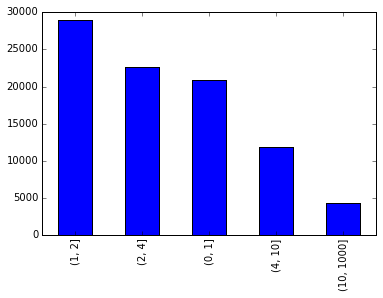

In [28]:
pd.Series(trip_dist_bin_id).value_counts().plot(kind='bar')

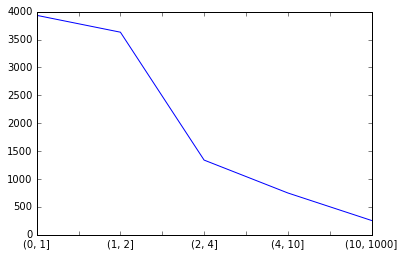

In [20]:
pd.Series(trip_dist_bin_id).value_counts().plot(kind='line')

We can also use bar plots for visualizing the sum of passengers for each vendor as follows

In [21]:
vendor_passenger_sum = df1.groupby('vendor_id').passenger_count.sum()
print vendor_passenger_sum

vendor_id
CMT    7997
VTS    8129
Name: passenger_count, dtype: int64


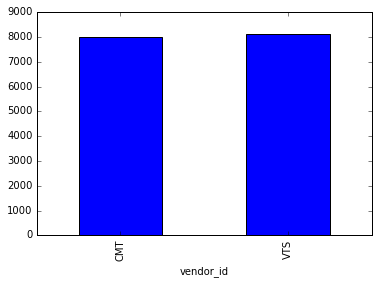

In [22]:
vendor_passenger_sum.plot(kind='bar')

#### Scatterplot 

We plot a scatter plot between trip_time_in_secs and trip_distance to see if there is any correlation between them.

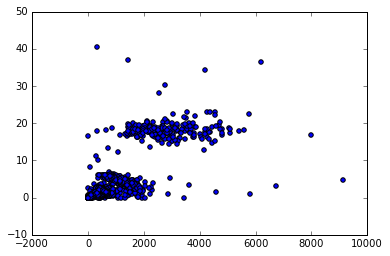

In [23]:
plt.scatter(df1['trip_time_in_secs'], df1['trip_distance'])

To further drill down on the relationship we can plot distribution side by side with the scatter plot (while flipping independentand dependent variables) as follows

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90775c96d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f907724c210>]], dtype=object)

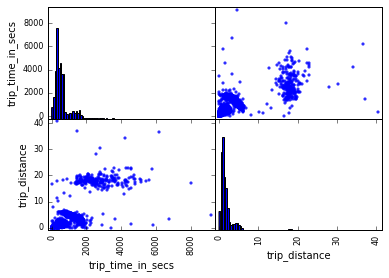

In [24]:
df1_2col = df1[['trip_time_in_secs','trip_distance']]
pd.scatter_matrix(df1_2col, diagonal='hist', color='b', alpha=0.7, hist_kwds={'bins':100})

Similarly we can check the relationship between rate_code and trip_distance using a scatter plot

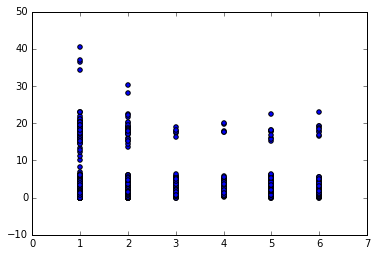

In [25]:
plt.scatter(df1['passenger_count'], df1['trip_distance'])

#### Correlation

Pandas 'corr' function can be used to compute the correlation between trip_time_in_secs and trip_distance as follows:

In [26]:
df1[['trip_time_in_secs', 'trip_distance']].corr()

,trip_time_in_secs,trip_distance
trip_time_in_secs,1.000000,0.761428
trip_distance,0.761428,1.000000


## Sub-Sampling the Data in SQL

In this section we used a sampled table we pregenerated by joining Trip and Fare data and taking a sub-sample of the full dataset. 

Please note that we are have created a sampled table named 'nyctaxi_sample'. If a table with this name already exists please rename the table in the code below. Also, if you have run this code once and created the table already, re-executing the code to create the table will fail and inserting into an existing table will result in potentially duplicate data being inserted. You can drop the table using the code below if required.

#### Report number of rows and columns in the sampled table

In [27]:
nrows = pd.read_sql('''SELECT SUM(rows) FROM sys.partitions WHERE object_id = OBJECT_ID('nyctaxi_sample')''', conn)
print 'Number of rows in sample = %d' % nrows.iloc[0,0]

ncols = pd.read_sql('''SELECT count(*) FROM information_schema.columns WHERE table_name = ('nyctaxi_sample')''', conn)
print 'Number of columns in sample = %d' % ncols.iloc[0,0]

Number of rows in sample = 2800275
Number of columns in sample = 21


We show some examples of exploring data using SQL in the sections below. We also show some useful visualizatios that you can use below. Note that you can read the sub-sample data in the table above in Azure Machine Learning directly using the SQL code in the reader module. 

## Exploration in SQL

In this section, we would be doing some explorations using SQL on the 1% sample data (that we created above).

#### Tipped/Not Tipped Distribution

In [31]:
query = '''
        SELECT tipped, count(*) AS tip_freq
        FROM nyctaxi_sample
        GROUP BY tipped
        '''

pd.read_sql(query, conn)

,tipped,tip_freq
0,1,1460874
1,0,1339401


#### Tip Class Distribution

In [32]:
query = '''
        SELECT tip_class, count(*) AS tip_freq
        FROM nyctaxi_sample
        GROUP BY tip_class
'''

tip_class_dist = pd.read_sql(query, conn)
tip_class_dist

,tip_class,tip_freq
0,1,1328155
1,2,100397
2,3,31025
3,0,1339401
4,4,1297


#### Plot the tip distribution by class

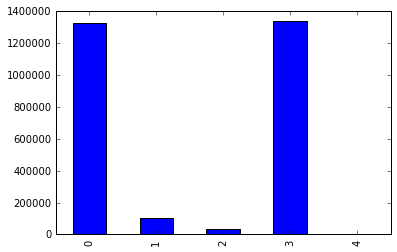

In [33]:
tip_class_dist['tip_freq'].plot(kind='bar')

#### Daily distribution of trips

In [34]:
query = '''
        SELECT CONVERT(date, dropoff_datetime) as date, count(*) as c 
        from nyctaxi_sample 
        group by CONVERT(date, dropoff_datetime)
        '''
pd.read_sql(query,conn)

,date,c
0,2013-01-23,8623
1,2013-01-03,7159
2,2013-04-09,7601
3,2013-01-15,7838
4,2013-03-25,7155
5,2013-03-09,9112
6,2013-01-16,8182
7,2013-02-20,8191
8,2013-01-08,7084
9,2013-01-09,7184


#### Trip distribution per medallion

In [35]:
query = '''select medallion,count(*) as c from nyctaxi_sample group by medallion'''
pd.read_sql(query,conn)

,medallion,c
0,3BD5C377A1572BB4D5C10AE58DAD0D72,260
1,081CF2DD59C52BCA3181F5E8F0061204,193
2,87CDD10EC56CB55A6F92D872A16AECCD,297
3,F5BF1495E877B9E3A69E78768543C42B,274
4,A1820C0C2A66AE0404C695FEA70C5969,250
5,5CE3B00595DE0A02E0CBF874BE4267D4,261
6,CAC69BD0D9A1095BA6501BD6DE457C12,136
7,D2FC9D75530B8AFB55F02DBACAE7B252,234
8,317DD70D01AB8C90468335BCA96D5D9C,236
9,ADDB6F51BFFAFA8603840526A7923A51,243


#### Trip distribution by medallion and hack license

In [36]:
query = '''select medallion, hack_license,count(*) from nyctaxi_sample group by medallion, hack_license'''
pd.read_sql(query,conn)

,medallion,hack_license,hack_license
0,F806784A27ED16C199E56E90CBBFA7AB,ABD96750762FA704625E4401842866F7,2
1,FD2743EF2EE177B988235BD85890C338,5D46978A586B3B1ED728AC0D856FB86D,2
2,2EEA0FB6D6416D8A23A9206978FE906C,CD7BEA4727CDF5D2988B47C81E8F1B98,2
3,747A12F2A7D11FF360800DE10731AEE3,5C646EAC45466D6E883DA551A59E1D2D,24
4,473D1C6B39C5BDD8BAE1E4822DDB4E84,BF49EC64C439F9EFFC250FBCB6B8415E,89
5,9469A9FBF25EB36248B2649FC8E31B5F,6DBD78CA76F9499A596D6332A8FDD7D1,28
6,5DB04ACE041C02E42BC57A25FF037AFA,5018F4FABC18C16746EB308CE671E574,2
7,5EE2C4D3BF57BDB455E74B03B89E43A7,D002FCD0631A3F18B16B91431A3A6803,1
8,39A60F14324688F6BB35EE079D492156,F9B5D1564EDCDB20A68AE9B2990AC627,3
9,E32D4FCF0F58010A4F021E3C36D780A6,DF7BD6A6798D6F1B13D7F0F0ECC2F618,1


#### Trip time distribution

In [42]:
query = '''select trip_time_in_secs, count(*) from nyctaxi_sample group by trip_time_in_secs order by count(*) desc'''
pd.read_sql(query,conn)

,trip_time_in_secs,trip_time_in_secs
0,360,95090
1,420,94759
2,300,91369
3,480,91233
4,540,86159
5,240,81487
6,600,80055
7,660,73790
8,720,66489
9,180,61480


#### Trip distance distribution

In [43]:
query = '''select floor(trip_distance/5)*5 as tripbin, count(*) from nyctaxi_sample group by floor(trip_distance/5)*5 order by count(*) desc'''
pd.read_sql(query,conn)

,tripbin,tripbin
0,0,2412490
1,5,249008
2,10,75338
3,15,51668
4,20,10043
5,25,1031
6,30,326
7,35,172
8,40,70
9,45,35


#### Payment type distribution

In [44]:
query = '''select payment_type,count(*) from nyctaxi_sample group by payment_type'''
pd.read_sql(query,conn)

,payment_type,payment_type
0,CSH,1284657
1,DIS,1991
2,UNK,3141
3,CRD,1504045
4,NOC,6441


In [45]:
query = '''select TOP 10 * from nyctaxi_sample'''
pd.read_sql(query,conn)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tolls_amount,total_amount,tip_amount,tipped,tip_class
0,0E6E411C233093FF928C85703B29DC78,F59F2299B41EFA29C6D668F54D8D2868,CMT,1,N,2013-10-20 12:01:07,2013-10-20 12:06:49,1,342,0.90,...,40.779232,CSH,6.0,0,0.5,0,6.5,0,0,0
1,BBAA52836EC682D5B5144247A68C92C9,EE8ACD83A7CFA0A07B8B0E1C8AFE91A6,CMT,1,N,2013-09-05 09:01:07,2013-09-05 09:04:11,1,184,0.80,...,40.783203,CSH,5.0,0,0.5,0,5.5,0,0,0
2,EBBFBE716BB21C3AC1A7EF307882445A,954E411BE76CDD3AF115C70AC3824C5F,CMT,1,N,2013-06-01 11:01:10,2013-06-01 11:08:45,1,455,0.80,...,40.760468,CSH,6.5,0,0.5,0,7.0,0,0,0
3,64D58FFD6E680C44A48E2481271DB328,2FC56667DFA08918B22BA89A089FAD41,CMT,1,N,2013-03-27 07:01:33,2013-03-27 07:07:12,2,339,1.50,...,40.758049,CSH,6.5,0,0.5,0,7.0,0,0,0
4,B620FF1CD0B80A120894F7A1D376582D,76AC51FFFF22C9A6416560A8F70E2CB0,CMT,1,N,2013-05-11 16:01:14,2013-05-11 16:06:54,1,339,0.60,...,40.756706,CSH,5.5,0,0.5,0,6.0,0,0,0
5,24E01BB2FCAD71BF03D320896921B969,0A6824E97AC3EDB1EDEAF27F278F32BA,CMT,1,N,2013-07-24 08:01:07,2013-07-24 08:05:24,1,257,1.00,...,40.788307,CSH,5.5,0,0.5,0,6.0,0,0,0
6,D72C164FE66ADFFFE94472B10DA5F9E3,87511560B98F6289718EAF3B42F060EE,CMT,1,N,2013-04-04 13:01:26,2013-04-04 13:07:14,1,347,0.70,...,40.715866,CSH,5.5,0,0.5,0,6.0,0,0,0
7,BD5317D1D1FB7E492B96E2B1DE9712DB,978AF33434F17E462C85CCC11CA5B4D2,CMT,1,N,2013-01-06 10:01:46,2013-01-06 10:07:05,2,319,1.00,...,40.74213,CSH,6.0,0,0.5,0,6.5,0,0,0
8,E5A71AB7F8D74511B46ABD8A894CC870,30553B08EC1E955BFA38B736BB3C20A8,CMT,1,N,2013-06-24 09:01:01,2013-06-24 09:07:56,3,415,0.80,...,40.759903,CSH,6.0,0,0.5,0,6.5,0,0,0
9,3FAFB068899C0B37C580E623B70C5A56,024F44725B5C8B1A2AC3FAF982F52429,VTS,1,,2013-09-02 09:01:00,2013-09-02 09:05:00,1,240,1.51,...,40.730022,CSH,6.5,0,0.5,0,7.0,0,0,0


We have now explored the data and can import the sampled data in Azure Machine Learning, add some features there and  predict things like whether a tip will be given (binary class), the tip amount (regression) or the tip amount range (multi-class)